In [1]:
%load_ext autoreload
%autoreload 2

#### Step 4: Measure Protein Coordinates from Segmentation Maps

In this step, we aim to extract protein coordinates from the segmentation masks generated in previous steps. These masks represent the predicted locations of proteins within the tomograms. To accurately identify and localize these proteins, we perform a series of filtering and extraction processes based on the anticipated size of the proteins.

In [3]:
from model_explore.extract import localize
from model_explore import utils, io
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import copick

########### Input Parameters ###########

config = '/mnt/simulations/ml_challenge/ml_config.json'
voxel_size = 10
seg_info = ['predict', 'DeepFindET', '1']
# Lets Run Localization on a few tomograms that were held out for testing
run_ids = ['TS_4', 'TS_17']

# Localization Parameters
method = 'watershed'        # Watershed or Center of Mass (CoM)
filter_size = 10            # Filter Size for Watershed or 3D
radius_min_scale = 0.5      # Minimum Radius Scale for Potential Picks
radius_max_scale = 1.5      # Maximum Radius Scale for Potential Picks

# Output Parameters
pick_objects = None         # Extract All Pickable Objects or Specific Objects?
pick_session_id = '1'       # Session ID for Writing Pickable Objects
pick_user_id = 'DeepFindET' # User ID for Writing Pickable Objects

In [4]:
# Load the Copick Project
root = copick.from_file(config)

# Get objects that can be Picked
objects = [(obj.name, obj.label, obj.radius) for obj in root.pickable_objects if obj.is_particle]

# Filter elements
if pick_objects is not None:
    objects = [obj for obj in objects if obj[0] in pick_objects]

print(f'Running Localization on the Following Objects: ')
print(', '.join([f'{obj[0]} (Label: {obj[1]})' for obj in objects]) + '\n')

# Either Specify Input RunIDs or Run on All RunIDs
if run_ids:  print('Running Localization on the Following run_ids: ' + ', '.join(run_ids) + '\n')
run_ids = run_ids if run_ids else [run.name for run in root.runs]
n_run_ids = len(run_ids)

Running Localization on the Following Objects: 
apoferritin (Label: 2), beta-amylase (Label: 3), beta-galactosidase (Label: 4), ribosome (Label: 5), thyroglobulin (Label: 6), virus-like-particle (Label: 7)

Running Localization on the Following run_ids: TS_4, TS_17



In [13]:
# Iterate over each run
for runID in tqdm(run_ids):
    
    # Get the run
    run = root.get_run(runID)
    
    # Localization
    localize.processs_localization(
        run, objects, seg_info, 
        method, voxel_size, filter_size, 
        radius_min_scale, radius_max_scale, 
        pick_session_id, pick_user_id)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [02:15<00:00, 67.86s/it]


#### (Optional, Visualize the Picks)

We've been able to convert the segmentation maps into 3D coordinates. Let's display these coordinates as a scatter plot. While here I'm displaying the results with Matplotlib, there is a great [ChimeraX extension](https://cxtoolshed.rbvi.ucsf.edu/apps/chimeraxcopick) that generalizes this visualization process in a seemless manner.


In [7]:
# Read the Copick Project
root = copick.from_file(config)

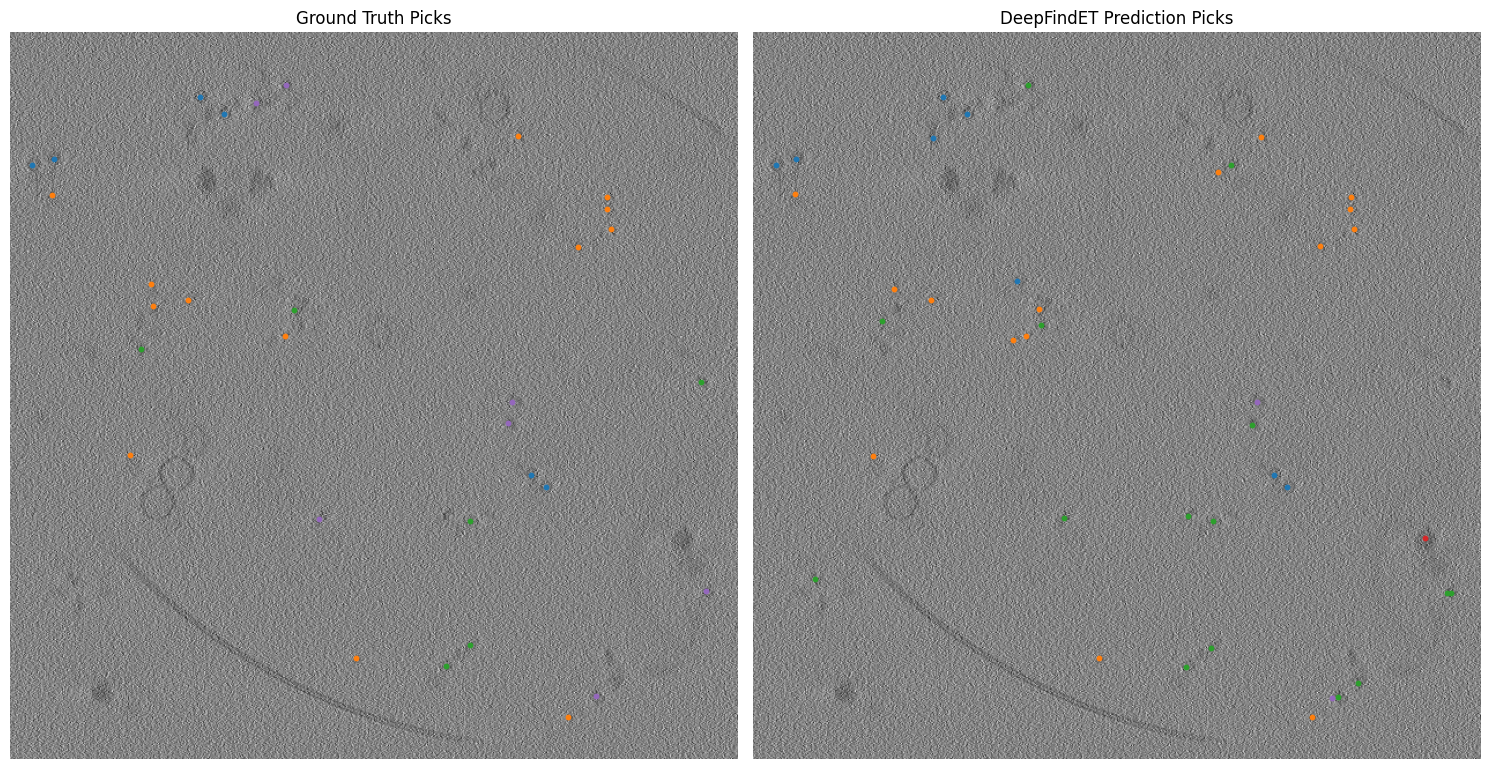

In [27]:
tomo_index = 0
vol_slice = 90
tomo_algorithm = 'wbp'

# Threshold for how close a point needs to be to the slice to be considered
slice_proximity_threshold = 3  

# Get the run and associated tomogram
run = root.get_run(run_ids[tomo_index])
vol = io.get_tomogram_array(run, voxel_size, tomo_algorithm)

# Plot the images
plt.figure(figsize=(15, 8))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Ground Truth Picks')
plt.imshow(vol[vol_slice],cmap='gray')
plt.axis('off')

# Plot each object from ground truth data
for name,_,_ in objects:

    coordinates = io.get_copick_coordinates(run, name=name, user_id='polnet')
    
    # Find points that are closest to the slice at Z = volSlice (90)
    close_points = coordinates[np.abs(coordinates[:, 0] - vol_slice) <= slice_proximity_threshold]

    # Plot the points on the image
    plt.scatter(close_points[:, 2], close_points[:, 1], label=name, s=10)

# Tomogram plot
plt.subplot(1, 2, 2)
plt.title('DeepFindET Prediction Picks')
plt.imshow(vol[vol_slice], cmap='gray')
plt.axis('off')

# Plot each object from ground truth data
for name,_,_ in objects:

    coordinates = io.get_copick_coordinates(run, name=name, user_id='DeepFindET')
    
    # Find points that are closest to the slice at Z = volSlice (90)
    close_points = coordinates[np.abs(coordinates[:, 0] - vol_slice) <= slice_proximity_threshold]

    # Plot the points on the image
    plt.scatter(close_points[:, 2], close_points[:, 1], label=name, s=10)

plt.tight_layout()
plt.show()

#### Step 5: Evalaute the Measured Coordinates

In the final step of evaluating measured coordinates, we use metrics such as recall, precision, accuracy, and F1 score to assess the performance of the trained model. These metrics help us understand how well the model identifies and localizes proteins or particles within the dataset. Refer to the cell bellow to get a description of all the metrics.

When working with synthetic data, where ground truths are certain, these metrics provide a clear indication of model performance, with high values reflecting a model that accurately identifies and localizes proteins as defined by the ground truth.

In experimental data, however, these metrics require more careful interpretation. For example, a high recall might indicate that the model is identifying true proteins that were not labeled during manual annotation, while precision could reflect the challenge of validating these detections against potentially incomplete ground truths.

In [9]:
from model_explore import evaluate

# Create the Evaluator
eval = evaluate.evaluator(
    config, 
    'polnet', '0', 
    'DeepFindET', '1', 
    object_names=None)

# Now Lets Run the Evaluation
eval.run(save_path='results', distance_threshold_scale=0.8, runIDs=run_ids)

Running Evaluation on the Following Copick Project:  /mnt/simulations/ml_challenge/ml_config.json

Ground Truth Query: 
UserID: polnet, SessionID: 0

Submitted Picks: 
UserID: DeepFindET, SessionID: 1

No object names provided, using all pickable objects
Using the following valid objects: ['apoferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

Running Metrics Evaluation on the Following RunIDs:  ['TS_4', 'TS_17']

Average Metrics Summary:
apoferritin: [Recall: 0.993 ± 0.003, Precision: 0.983 ± 0.013, False_Positives: 5.0 ± 4.0, False_Negatives: 2.0 ± 1.0]
beta-amylase: [Recall: 0.890 ± 0.037, Precision: 0.746 ± 0.081, False_Positives: 79.5 ± 28.5, False_Negatives: 28.0 ± 9.0]
beta-galactosidase: [Recall: 0.690 ± 0.054, Precision: 0.536 ± 0.011, False_Positives: 85.5 ± 3.5, False_Negatives: 45.0 ± 11.0]
ribosome: [Recall: 1.000 ± 0.000, Precision: 1.000 ± 0.000, False_Positives: 0.0 ± 0.0, False_Negatives: 0.0 ± 0.0]
thyroglobulin: [Rec